# Convolutional Neural Network 구현
- MNIST 손글씨 data를 이용하여 CNN을 학습하고 MLP와 결과와 비교.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
# 학습결과 그래프 함수
# loss 그래프
def plot_loss(history):
#     plt.figure(figsize=(10,7))
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [ ]:
# accuracy 그래프
def plot_accuracy(history):
#     plt.figure(figsize=(10,7))
    plt.plot(history.history['accuracy'], label='Train accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

# MNIST CNN 적용

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Input
import numpy as np

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
# 하이퍼파라미터 설정
LEARNING_RATE = 0.001
N_EPOCHS = 20
N_BATCHS = 100
N_CLASS = 10

In [ ]:
# 데이터셋 로드
(train_image, train_label), (test_image, test_label) = keras.datasets.mnist.load_data()
train_image.shape, train_label.shape, test_image.shape, test_label.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [ ]:
# 추가 변수 설정
N_TRAIN = train_image.shape[0]
N_TEST = test_image.shape[0]

In [ ]:
# 전처리: 이미지 - 정규화(0 ~ 1)
#         label - onehotencoding(생략-loss: sparse_categorical_crossentropy)
X_train, X_test = train_image/255., test_image/255.
X_train, X_test  = X_train[..., np.newaxis], X_test[..., np.newaxis] # channel 축 추가 작업
y_train, y_test = train_label, test_label
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
# dataset 구성
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(N_TRAIN).batch(N_BATCHS, drop_remainder=True).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCHS)

# CNN 모델 구성
- convolution layer의 filter 개수는 적은 개수에서 점점 늘려간다.
- input shape(입력데이터의 size) : 3차원(height, width, channel)
  - 흑백:(height, width, 1)
  - 컬러:(height, width, 3)

In [ ]:
def create_model():
  model = keras.Sequential()
  model.add(layers.Input((28,28,1))) # Input shape
  # Convolution layer: Conv2D -> MaxPool2D
  model.add(layers.Conv2D(filters=32, # Filter 개수
                          kernel_size=(3,3), # Filter(kernel)의 height, width, h/w가 같은 경우에는 정수
                          padding='same', # Padding방식: 'valid', 'same' - 대소문자 무관
                          strides=(1,1), # Strides 설정: (상하). 상하/좌우 같을 시 정수
                          activation='relu'))
  # Max Pooling layer => MaxPool2D
  model.add(layers.MaxPool2D(pool_size=(2,2), # 영역 height,width 크기 지정, h/w 같을 시 정수. default=(2,2)
                             strides=(2,2), # dafault: None => pool_size를 사용, 두개 값이 같을 시 정수
                             padding='same')) # "valid" - 뒤에 남는 것은 버린다
  model.add(layers.Conv2D(filters=64,
                          kernel_size=3,
                          padding='same',
                          strides=1,
                          activation='relu'))
  model.add(layers.MaxPool2D(padding='same')) # pool_size, strides: dafault 값으로 설정

  # Classification Layer -> Fully Connected Layer
  # Conv 거친 Feature map은 3차원 형태
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))

  # 출력
  model.add(layers.Dense(N_CLASS, activation='softmax'))

  return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               803072    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2

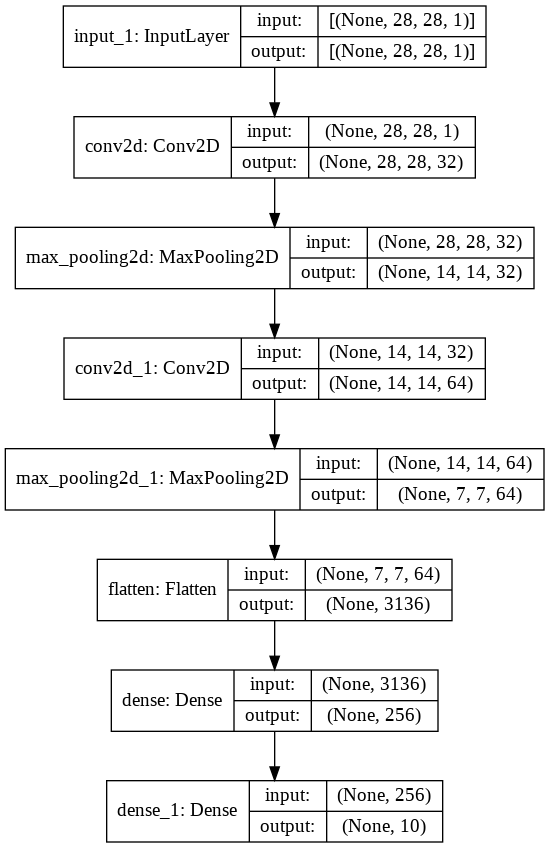

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='sparse_categorical_crossentropy', # sparse_catetorical_crossentropy: y가 one hot encoding이 안된 경우 사용
              metrics=['accuracy'])

In [ ]:
y_test.shape

(10000,)

In [ ]:
steps_per_epoch = N_TRAIN // N_BATCHS
validation_steps = int(np.ceil(N_TEST / N_BATCHS))

history = model.fit(train_dataset,
                    epochs=N_EPOCHS,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=test_dataset,
                    validation_steps=validation_steps)

Epoch 1/20
600/600 [==============================] - 36s 5ms/step - loss: 0.3780 - accuracy: 0.8821 - val_loss: 0.0415 - val_accuracy: 0.9862
Epoch 2/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0454 - accuracy: 0.9863 - val_loss: 0.0356 - val_accuracy: 0.9887
Epoch 3/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0273 - accuracy: 0.9916 - val_loss: 0.0279 - val_accuracy: 0.9912
Epoch 4/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0220 - accuracy: 0.9934 - val_loss: 0.0325 - val_accuracy: 0.9888
Epoch 5/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0172 - accuracy: 0.9945 - val_loss: 0.0258 - val_accuracy: 0.9911
Epoch 6/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0133 - accuracy: 0.9958 - val_loss: 0.0298 - val_accuracy: 0.9901
Epoch 7/20
600/600 [==============================] - 3s 4ms/step - loss: 0.0097 - accuracy: 0.9968 - val_loss: 0.0352 - val_accuracy: 0.9890
Epoch

In [ ]:
model.evaluate(test_dataset)

100/100 [==============================] - 0s 3ms/step - loss: 0.0284 - accuracy: 0.9936


[0.02835252322256565, 0.9936000108718872]

In [ ]:
# 새로운 데이터 추론
pred = model.predict(X_test[:10])
pred_class = np.argmax(pred, axis=-1)

In [ ]:
pred_class, y_test[:10]

(array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]),
 array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8))

### prediction error가 발생한 example 확인

In [ ]:
pred = model.predict(X_test)
pred_class = np.argmax(pred, axis=-1)
pred_class[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [ ]:
# pred_class: 예측결과, y_test: 실제정답
# 예측이 틀린 index를 조회
error_idx = np.where(pred_class!=y_test)[0]
error_idx.size, error_idx

(64, array([  18,  247,  321,  582,  659,  883,  947, 1014, 1112, 1226, 1232,
        1260, 1393, 1459, 1549, 1621, 1709, 1901, 2070, 2129, 2130, 2293,
        2369, 2414, 2488, 2597, 2654, 2896, 2939, 2953, 2959, 3225, 3422,
        3520, 3558, 3727, 3808, 3941, 4156, 4176, 4199, 4380, 4504, 4723,
        4740, 4761, 4823, 4860, 5937, 5981, 6091, 6560, 6576, 6625, 6651,
        7216, 7354, 7574, 8408, 9009, 9664, 9692, 9729, 9839]))

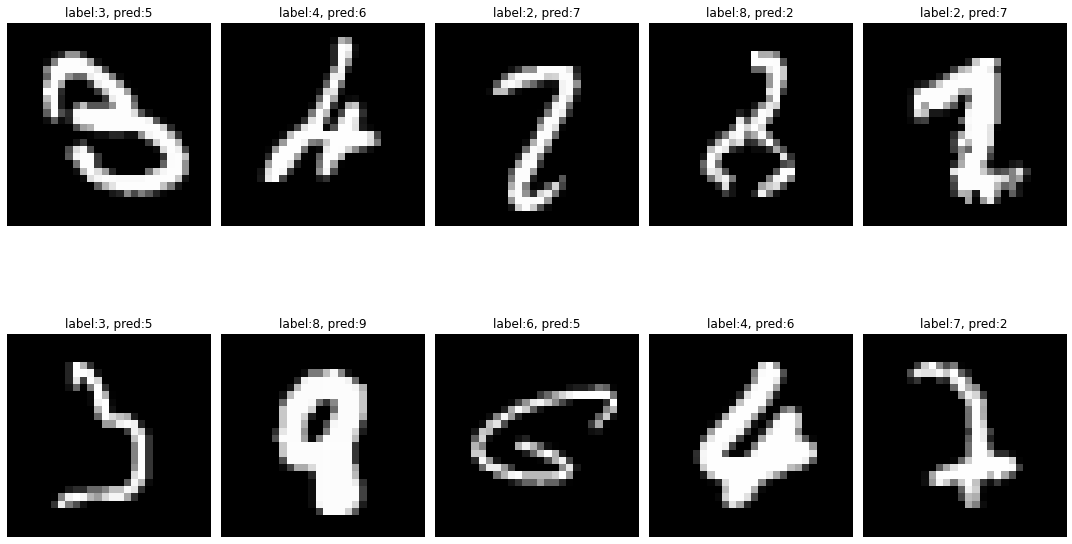

In [ ]:
# 틀린 것 10개 확인
plt.figure(figsize=(15,10))
for i in range(10):
  err = error_idx[i]
  plt.subplot(2,5, i+1)
  plt.imshow(test_image[err], cmap='gray')
  plt.title(f'label:{y_test[err]}, pred:{pred_class[err]}')
  plt.axis('off')
plt.tight_layout()
plt.show()

# 모델 저장
1. 학습이 끝난 모델의 파라미터만 저장
1. 모델 전체 저장
1. Callback 함수를 이용해 학습시 가장 좋은 지표의 모델 저장

## 텐서플로 파일 타입
- checkpoint 
    - 모델의 weight를 저장하기 위한 파일타입
- SavedModel 
    - 모델의 구조와 파라미터들을 모두 저장하는 형식

## 학습한 Weight (파라미터) 저장 및 불러오기
- 가중치를 저장하여 나중에 재학습 없이 학습된 가중치를 사용할 수 있다.
- 저장: `model.save_weights("저장경로")`
- 불러오기: `model.load_weights('불러올경로')`
- 저장형식
    - Tensorflow Checkpoint (기본방식)
    - HDF5
        - `save_weights(.., save_format='h5')`

In [ ]:
# 저장할 경로 생성
import os
base_dir = "/content/drive/MyDrive/Colab Notebooks/Playdata/saved_models" # 모델/파라미터들을 저장할 root
weight_dir = os.path.join(base_dir, 'mnist', 'weights')
print(weight_dir)
if not os.path.isdir(weight_dir):
  os.makedirs(weight_dir, exist_ok=True) # exist_ok=False(default): 이미 경로가 있으면 예외발생, True: 예외발생 없음
weight_path = os.path.join(weight_dir, 'mnist_cnn_weights.ckpt') # 저장할 디렉토리 + 파일명

/content/drive/MyDrive/Colab Notebooks/Playdata/saved_models/mnist/weights


In [ ]:
model.save_weights(weight_path)

In [ ]:
new_model1 = create_model()
new_model1.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='sparse_categorical_crossentropy', # sparse_catetorical_crossentropy: y가 one hot encoding이 안된 경우 사용
              metrics=['accuracy'])

In [ ]:
new_model1.evaluate(test_dataset)

100/100 [==============================] - 1s 3ms/step - loss: 2.3126 - accuracy: 0.1780


[2.313303232192993, 0.17180000245571136]

In [ ]:
# 파일로 저장된 weight들을 생성된 모델(네트워크)에 저장
new_model1.load_weights(weight_path)

In [ ]:
new_model1.evaluate(test_dataset)

100/100 [==============================] - 0s 3ms/step - loss: 0.0284 - accuracy: 0.9936


[0.02835252322256565, 0.9936000108718872]

In [ ]:
# new_model1.fit() # 이어서 학습

In [ ]:
# hdf5형식으로 저장/불러오기
weight_h5_dir = os.path.join(base_dir, 'mnist', 'weight_h5')
if not os.path.isdir(weight_h5_dir):
  os.makedirs(weight_h5_dir)

weight_h5_path = os.path.join(weight_h5_dir, 'mnist_cnn_weight.h5')
print(type(weight_h5_path), weight_h5_path)

<class 'str'> /content/drive/MyDrive/Colab Notebooks/Playdata/saved_models/mnist/weight_h5/mnist_cnn_weight.h5


In [ ]:
model.save_weights(weight_h5_path, save_format='h5')

In [ ]:
new_model2 = create_model()
new_model2.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='sparse_categorical_crossentropy', # sparse_catetorical_crossentropy: y가 one hot encoding이 안된 경우 사용
              metrics=['accuracy'])

In [ ]:
new_model2.evaluate(test_dataset)

100/100 [==============================] - 1s 3ms/step - loss: 2.2881 - accuracy: 0.1026


[2.2876782417297363, 0.10239999741315842]

In [ ]:
new_model2.load_weights(weight_h5_path)
new_model2.evaluate(test_dataset)

100/100 [==============================] - 0s 3ms/step - loss: 0.0284 - accuracy: 0.9936


[0.02835252322256565, 0.9936000108718872]

## 전체 모델 저장하고 불러오기
- 저장: `model.save('저장할디렉토리')`
- 불러오기: `tf.keras.models.load_model('저장파일경로')`
- 저장 형식
    - Tensorflow SavedModel 형식(기본방식)
        - 모델 아키텍처 및 훈련 구성(옵티마이저, 손실 및 메트릭 포함)은 saved_model.pb 에 저장된다.
        - 파라미터는 variables/ 디렉토리에 저장된다.
        - https://www.tensorflow.org/guide/saved_model?hl=ko#the_savedmodel_format_on_disk
    - HDF5 형식
        - `save(..., save_format='h5')` 로 지정한다.
    

In [ ]:
model_dir = os.path.join(base_dir, 'mnist', 'models', 'saved_model')
if not os.path.isdir(model_dir):
  os.makedirs(model_dir, exist_ok=True)
print(model_dir)

/content/drive/MyDrive/Colab Notebooks/Playdata/saved_models/mnist/models/saved_model


In [ ]:
model.save(model_dir) # SaveModel 형식으로 저장시 디렉토리 지정

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Playdata/saved_models/mnist/models/saved_model/assets


In [ ]:
new_model3 = keras.models.load_model(model_dir)

In [ ]:
new_model3.summary()

In [ ]:
new_model3.evaluate(test_dataset)

100/100 [==============================] - 0s 3ms/step - loss: 0.0284 - accuracy: 0.9936


[0.02835252322256565, 0.9936000108718872]

In [ ]:
# h5형식으로 저장/불러오기
model_h5_dir = os.path.join(base_dir, 'mnist', 'models', 'h5_model')
if os.path.isdir(model_h5_dir):
  os.makedir(model_h5_dir, exist_ok=True)
# h5 형식으로 저장 시 파일명까지 지정
model_h5_path = os.path.join(model_h5_dir, 'mnist_cnn_model.h5')

In [ ]:
model.save(model_h5_path, save_format='h5')

In [ ]:
new_model4 = keras.models.load_model(model_h5_path)

In [ ]:
new_model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               803072    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2

In [ ]:
new_model4.evaluate(test_dataset)

100/100 [==============================] - 0s 3ms/step - loss: 0.0284 - accuracy: 0.9936


[0.02835252322256565, 0.9936000108718872]

## Callback을 사용한 모델 저장 및 Early Stopping
- callback은 학습하는 도중 특정 이벤트 발생시 호출되는 다양한 함수를 제공하여 자동화 처리를 지원한다. (cf: 프로그래밍의 콜백함수)
- 다양한 콜백 클래스가 제공된다.
    - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
- `EarlyStopping`: Validation set에 대한 평가지표가  더 이상 개선되지 않을 때 학습을 자동으로 멈춤
    - `monitor`: 모니터링할 평가지표 지정. (ex: accuracy)
    - `patience`: epoch 수 지정. validation 평가 지표가 개선이 안되더라도 지정한 epoch만큼 반복한다. 지정한 epoch만큼 반복 후에도 개선이 되지 않으면 중단한다. 
- `ModelCheckpoint`: 지정한 평가지표(예:validation loss)가 가장 좋을 때 모델과 weight를 저장하여 overfitting이 발생하기 전의 model을 나중에 불러들여 사용할 수 있음
    - `save_best_only=True`: monitoring 중인 measure를 기준으로 최적의 모형의 weight만 저장 
- **callback 객체들을 리스트로 묶은 뒤 fit()의 callback 매개변수에 전달한다.**

In [ ]:
model2 = create_model()
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model2.evaluate(test_dataset)

100/100 [==============================] - 1s 3ms/step - loss: 2.3079 - accuracy: 0.0971


[2.3085758686065674, 0.10509999841451645]

In [ ]:
callback_dir = os.path.join(base_dir, 'mnist', 'models', 'callback')
if not os.path.isdir(callback_dir):
  os.makedirs(callback_dir, exist_ok=True)
callback_path = os.path.join(callback_dir, 'save_model_{epoch:02d}.ckpt') # {epoch:02d} - 포멧문자열. 몇번 쨰 에폭의 저장포인트인지

In [ ]:
# ModelCheckpoint callback 생성
mc_callback = keras.callbacks.ModelCheckpoint(filepath=callback_path, # 학습 도중 모델/파라미터 저장할 경로
                                              save_weights_only=True, # True: 가중치 저장, False(default): 모델+가중치 저장
                                              save_best_only=True, # True: 가장 성능이 좋았을 당시에만 저장. False(default): 매 에폭마다 저장.
                                              monitor='val_loss', # save_best_only=True 일 때 성능확인할 평가지표
                                              verbose=1 # 저장할 때마다 로그 출력
                                              )

# EarlyStopping callback 생성
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5) # 5 에폭 학습하는 동안 val_loss가 개선되지 않으면 학습 중단)

In [ ]:
model2.fit(train_dataset,
          epochs=N_EPOCHS,
          steps_per_epoch=steps_per_epoch,
          validation_data=test_dataset,
          validation_steps=validation_steps,
          callbacks=[mc_callback, es_callback])

Epoch 1/20
600/600 [==============================] - 4s 6ms/step - loss: 1.9187e-06 - accuracy: 1.0000 - val_loss: 0.0532 - val_accuracy: 0.9926

Epoch 00001: saving model to /content/drive/MyDrive/Colab Notebooks/Playdata/saved_models/mnist/models/callback/save_model_01.ckpt
Epoch 2/20
600/600 [==============================] - 3s 6ms/step - loss: 1.4685e-06 - accuracy: 1.0000 - val_loss: 0.0535 - val_accuracy: 0.9926

Epoch 00002: saving model to /content/drive/MyDrive/Colab Notebooks/Playdata/saved_models/mnist/models/callback/save_model_02.ckpt
Epoch 3/20
600/600 [==============================] - 3s 6ms/step - loss: 1.1471e-06 - accuracy: 1.0000 - val_loss: 0.0538 - val_accuracy: 0.9926

Epoch 00003: saving model to /content/drive/MyDrive/Colab Notebooks/Playdata/saved_models/mnist/models/callback/save_model_03.ckpt
Epoch 4/20
600/600 [==============================] - 3s 6ms/step - loss: 8.9333e-07 - accuracy: 1.0000 - val_loss: 0.0542 - val_accuracy: 0.9926

Epoch 00004: saving

In [ ]:
# 저장된 weight loading
new_model5 = create_model()
new_model5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# weight들이 저장된 디렉토리 지정시 마지막 에폭으로 저장된 weight 불러온다
best_weights = tf.train.latest_checkpoint(callback_dir)

In [ ]:
new_model5.load_weights(best_weights)

In [ ]:
new_model5.evaluate(test_dataset)

100/100 [==============================] - 1s 3ms/step - loss: 0.0670 - accuracy: 0.9910


[0.052877027541399, 0.9926000237464905]